# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

https://detectron2.readthedocs.io/en/latest/modules/engine.html#detectron2.engine.defaults.DefaultPredictor.metadata

https://detectron2.readthedocs.io/en/latest/modules/config.html

https://towardsdatascience.com/object-detection-in-6-steps-using-detectron2-705b92575578

# Install detectron2

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

In [ ]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo


In [ ]:
!pip install -e detectron2_repo

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [ ]:
# download, decompress the data
!wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
!unzip data.zip > /dev/null

In [ ]:
import pandas as pd
import random
import json
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

In [ ]:
tr_path ='/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/Train'
vl_path = '/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/Val'

In [ ]:
tr = pd.read_json('/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/Train/dict_train.json')
vl = pd.read_json('/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/Val/dict_val.json')
# with open(tr_path,'r') as f:
#   x=f.readlines()
# type(x)
# from itertools import islice
# a = islice(x,5,len(x))

# tr = pd.DataFrame.from_dict(x, orient='index')
# tr.head()

In [ ]:
# merged = pd.concat([tr,vl])
merged.tail()

,image_id,file_name,height,width,annotations
22,22,423.jpeg,162,358,"[{'bbox': [67, 12, 89, 60], 'bbox_mode': 1, 'c..."
23,23,424.jpeg,270,482,"[{'bbox': [18, 73, 185, 63], 'bbox_mode': 1, '..."
24,24,425.jpeg,357,382,"[{'bbox': [104, 66, 134, 45], 'bbox_mode': 1, ..."
25,25,426.jpeg,404,844,"[{'bbox': [33, 4, 303, 193], 'bbox_mode': 1, '..."
26,26,427.jpeg,720,960,"[{'bbox': [107, 262, 432, 195], 'bbox_mode': 1..."


In [ ]:
merged.to_json('/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/train_val.json', orient='records')

In [ ]:
with open(tr_path+'/dt.json') as f:
    dataset_dicts = json.load(f)
dataset_dicts[0]

{'annotations': [{'bbox': [122, 207, 173, 70],
   'bbox_mode': 1,
   'category_id': '0'},
  {'bbox': [291, 213, 181, 70], 'bbox_mode': 1, 'category_id': '0'},
  {'bbox': [464, 214, 117, 73], 'bbox_mode': 1, 'category_id': '0'}],
 'file_name': '0.jpeg',
 'height': 500,
 'image_id': 0,
 'width': 715}

In [ ]:

from detectron2.structures import BoxMode
json_file = '/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/train_val.json'
with open(json_file) as f:
    dataset_dicts = json.load(f)
for i in dataset_dicts:
  for j in i["annotations"]:
    j["bbox_mode"] = BoxMode.XYWH_ABS
    # print(j['category_id'])
print(dataset_dicts[0])

{'image_id': 0, 'file_name': '0.jpeg', 'height': 500, 'width': 715, 'annotations': [{'bbox': [122, 207, 173, 70], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': '0'}, {'bbox': [291, 213, 181, 70], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': '0'}, {'bbox': [464, 214, 117, 73], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': '0'}]}


In [ ]:

def get_board_dicts(imgdir):
    json_file = imgdir+'/dt.json' #Fetch the json file
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = imgdir+"/Images/"+filename 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS #Setting the required Box Mode
            j["category_id"] = int(j["category_id"])
    return dataset_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog
#Registering the Dataset
for d,i in zip([tr_path, vl_path],['train', 'valid']):
    DatasetCatalog.register("lang_detect1_"+i, lambda d=d: get_board_dicts(d))
    MetadataCatalog.get("lang_detect1_" + i).set(thing_classes=["HINDI","ENGLISH","OTHER"])
board_metadata = MetadataCatalog.get("lang_detect1_train")

In [ ]:
board_metadata

Metadata(name='lang_detect1_train', thing_classes=['HINDI', 'ENGLISH', 'OTHER'])

[{'image_id': 0, 'file_name': '/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/Train/Images/0.jpeg', 'height': 500, 'width': 715, 'annotations': [{'bbox': [122, 207, 173, 70], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [291, 213, 181, 70], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [464, 214, 117, 73], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}]}, {'image_id': 1, 'file_name': '/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/Train/Images/1.jpeg', 'height': 500, 'width': 715, 'annotations': [{'bbox': [13, 70, 156, 73], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [174, 59, 275, 57], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [448, 35, 172, 59], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}]}, {'image_id': 2, 'file_name': '/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/Train/Images/2.jpeg', 'height': 500, 'width': 715, 'ann

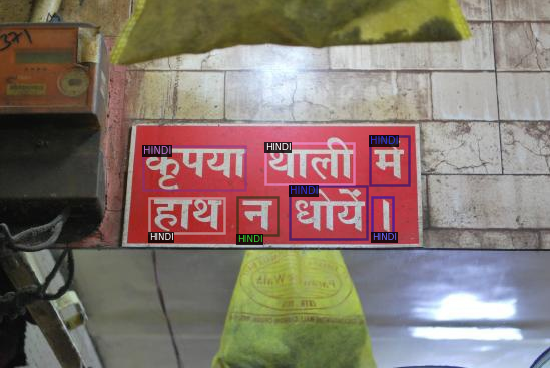

{'image_id': 88, 'file_name': '/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/Train/Images/88.jpeg', 'height': 500, 'width': 715, 'annotations': [{'bbox': [60, 279, 201, 48], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [269, 262, 98, 69], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [373, 263, 240, 67], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [622, 265, 83, 64], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [32, 332, 435, 155], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [477, 346, 217, 139], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}]}


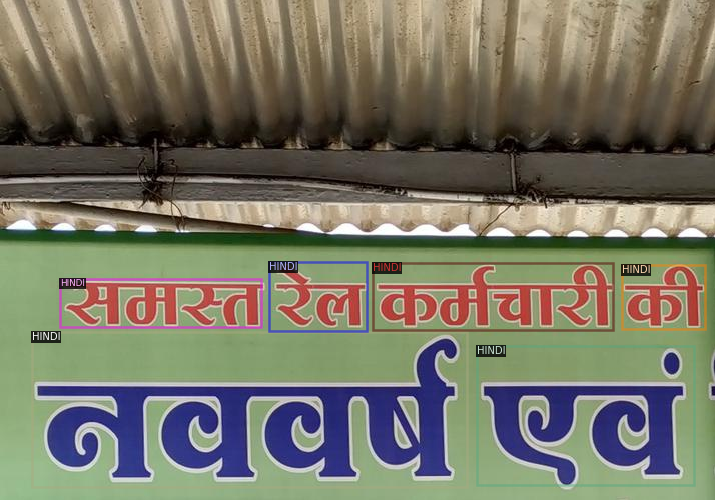

In [ ]:
dataset_dicts = get_board_dicts(tr_path)
print(dataset_dicts)
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    print(d)
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:


class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("lang_detect1_train")
cfg.DATASETS.TEST = ('lang_detect1_valid')   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") #'detectron2://ImageNetPretrained/MSRA/R-50.pkl")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)
cfg.TEST.EVAL_PERIOD = 100
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer =DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/08 09:23:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

AssertionError: ignored

In [ ]:
dataset_dicts = get_board_dicts(vl_path)
l =[]
for i in dataset_dicts:
  l.append(i['annotations'][0]['category_id'])
set(l)

{0, 1, 2}

In [ ]:
dataset_dicts = get_board_dicts(vl_path)
for entry in dataset_dicts:
        annos = entry["annotations"]
        classes = np.asarray(
            [x["category_id"] for x in annos if not x.get("iscrowd", 0)], dtype=np.int)
classes.max()
# len(classes)

0

In [ ]:
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'detectron2://ImageNetPretrained/MSRA/R-50.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
# from detectron2.data.datasets import register_coco_instances
# images_path = '/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/images'
# annotations_path = '/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/trainval.json'
# register_coco_instances("lang_detect_3", {}, annotations_path, images_path)

https://github.com/facebookresearch/detectron2/blob/2455e4790f470bba54299c049410fc0713ae7529/detectron2/data/datasets/coco.py#L474

In [ ]:
lang_detect_metadata = MetadataCatalog.get("lang_detect_3")
# dataset_dicts = DatasetCatalog.get("lang_detect_3")

In [ ]:
lang_detect_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/images', json_file='/content/drive/MyDrive/datasets/Text_Detection/Text Detection Dataset/trainval.json', name='lang_detect_3')

In [ ]:
f = open(annotations_path)
print(f.read())
d_dicts = {'image_id':[], 'file_name':[], 'height':[], 'width':[], 'annotations':[]}

In [ ]:
dataset_dicts = DatasetCatalog.get("fruit_nuts")

In [ ]:
# x = dataset_dicts[0]['annotations']
# x[0]['category_id']
category_dict = {}
for d in dataset_dicts:
  # print(d)
  print(len(d['annotations']))
  # for i in d['annotations'][0]:
  #   print(len(i))


12
9
6
12
13
8
12
6
2
11
8
12
8
12
6
8
9
11


In [ ]:
category_dict = {'file_name':[], 'category':[]}
for d in dataset_dicts:
  
  for i in x:
    category_dict['file_name'].append(d['file_name'])
    category_dict['file_name'].append(i['category_id'])
    # print(i)
category_dict


In [ ]:
category_dict

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [ ]:


for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("fruits_nuts",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("fruits_nuts", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='./data/images', json_file='./data/trainval.json', name='fruits_nuts', thing_classes=['date', 'fig', 'hazelnut'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2})

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.39,fps:2.59


In [ ]:
import random
import string

In [ ]:
res = ''.join(random.choices(string.ascii_uppercase+string.digits, k=5))
res


'9XD0T'

In [ ]:
paths= []
e_ld = []
for x in range(10):
  res = ''.join(random.choices(string.ascii_uppercase+string.digits, k=5))
  e_ld.append(res)
  res = '//sgfd//'+res+'/'
  paths.append(res)


In [ ]:
import time
t = time.time()
l = [i for i in range(len(paths))]
for e in e_ld:
  for k in l:
    if e in paths[k]:
      l.remove(k)
    # print(e)
e = time.time()

In [ ]:
e-t

0.00017833709716796875

In [ ]:
e-t

6.794929504394531e-05